# <center>Проект построения модели машинного обучения для регрессии</center>

In [40]:
# Импортируем все необходимые библиотеки

from numpy import arange, nan, array
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error

<p>Файл CSV включает почасовую/ежедневную сводку для Szeged, Венгрия, в период с 2006 по 2016 год.</p>

<p>Данные, доступные в почасовом ответе:</p>

- форматированная дата
- облачно/ясно/...
- осадки
- температура
- ощущение температуры
- влажность
- скорость ветра
- подшипник ветра (градусы)
- видимость (км)
- давление

In [2]:
filename = 'data/weatherHistory.csv'
df = read_csv(filename, index_col='Formatted Date') 
df = df.drop(['Loud Cover'], axis=1)
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
Formatted Date,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.


## Анализ данных

In [3]:
# размер данных
df.shape

(96453, 10)

In [4]:
# типы данных
df.dtypes

Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

Преобразуем данные в числовой формат

## Преобразование данных

Рассмотрим данные второго столбца и соберем все отличающиеся классификации

In [5]:
summary_values = []
for i in df['Summary']:
    if not i in summary_values:
        summary_values.append(i)

In [6]:
summary_values.sort()
summary_values

['Breezy',
 'Breezy and Dry',
 'Breezy and Foggy',
 'Breezy and Mostly Cloudy',
 'Breezy and Overcast',
 'Breezy and Partly Cloudy',
 'Clear',
 'Dangerously Windy and Partly Cloudy',
 'Drizzle',
 'Dry',
 'Dry and Mostly Cloudy',
 'Dry and Partly Cloudy',
 'Foggy',
 'Humid and Mostly Cloudy',
 'Humid and Overcast',
 'Humid and Partly Cloudy',
 'Light Rain',
 'Mostly Cloudy',
 'Overcast',
 'Partly Cloudy',
 'Rain',
 'Windy',
 'Windy and Dry',
 'Windy and Foggy',
 'Windy and Mostly Cloudy',
 'Windy and Overcast',
 'Windy and Partly Cloudy']

в соответствии каждому наименованию запишем числовую характеристику

In [7]:
s_v = {
 'Breezy': 1.0,
 'Breezy and Dry': 1.2,
 'Breezy and Foggy': 1.4,
 'Breezy and Mostly Cloudy': 1.6,
 'Breezy and Overcast': 1.8,
 'Breezy and Partly Cloudy': 2,
 'Clear': 3,
 'Dangerously Windy and Partly Cloudy': 4,
 'Drizzle': 5,
 'Dry': 6.3,
 'Dry and Mostly Cloudy': 6.6,
 'Dry and Partly Cloudy': 6.9,
 'Foggy': 8,
 'Humid and Mostly Cloudy': 9.3,
 'Humid and Overcast': 9.6,
 'Humid and Partly Cloudy': 9.9,
 'Light Rain': 11,
 'Mostly Cloudy': 12,
 'Overcast': 13,
 'Partly Cloudy': 14,
 'Rain': 15,
 'Windy': 16,
 'Windy and Dry': 16.2,
 'Windy and Foggy': 16.4,
 'Windy and Mostly Cloudy': 16.6,
 'Windy and Overcast': 16.8,
 'Windy and Partly Cloudy': 17
}

Создаем новый столбец с числовыми значениями

In [8]:
df['Summary_Nums'] = [s_v[i] for i in df['Summary']]

In [9]:
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Summary_Nums
Formatted Date,,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,14.0
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,14.0
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,12.0
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,14.0
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,12.0


Аналогичная процедура со столбцом Осадки

In [10]:
precip_type = []
for i in df['Precip Type']:
    if not i in precip_type:
        precip_type.append(i)
precip_type

['rain', 'snow', nan]

In [11]:
p_t = {
    'rain': 1,
    'snow': 2,
    nan: 0
}

In [12]:
df['Precip Type_Nums'] = [p_t[i] for i in df['Precip Type']]
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Summary_Nums,Precip Type_Nums
Formatted Date,,,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,14.0,1
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,14.0,1
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,12.0,1
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,14.0,1
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,12.0,1


Удаляем ненужные столбцы

In [13]:
fd = df.drop(['Daily Summary', 'Summary', 'Precip Type'], axis=1) # final_data
fd.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Nums,Precip Type_Nums
Formatted Date,,,,,,,,,
2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,14.0,1
2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,14.0,1
2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,12.0,1
2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,14.0,1
2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,12.0,1


<p></p>
<p></p>
<p></p>

## Анализ данных (продолжение)

In [14]:
# статистические характеристики
fd.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Nums,Precip Type_Nums
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,1003.235956,11.351565,1.105699
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,116.969906,3.627686,0.324420
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,1011.900000,12.000000,1.000000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,1016.450000,13.000000,1.000000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,1021.090000,14.000000,1.000000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000,17.000000,2.000000


In [15]:
# корреляция столбцов
fd.corr(method='pearson')

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Nums,Precip Type_Nums
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447,0.151813,-0.542245
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219,0.147532,-0.545264
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454,-0.119334,0.223896
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263,0.006164,-0.068319
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651,0.022712,-0.040390
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818,0.143173,-0.291999
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000,0.142475,0.006472
Summary_Nums,0.151813,0.147532,-0.119334,0.006164,0.022712,0.143173,0.142475,1.000000,-0.106826
Precip Type_Nums,-0.542245,-0.545264,0.223896,-0.068319,-0.040390,-0.291999,0.006472,-0.106826,1.000000


## Визуализация

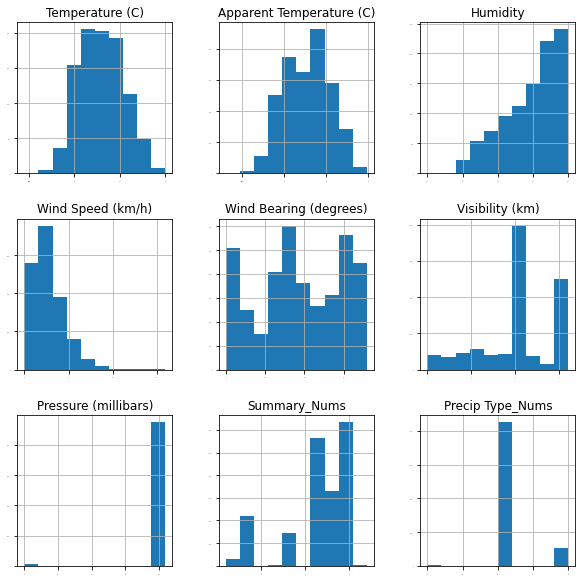

In [70]:
# гистограмма
fd.hist(xlabelsize=1, ylabelsize=1, sharex=False, figsize=(10,10))
pyplot.show()

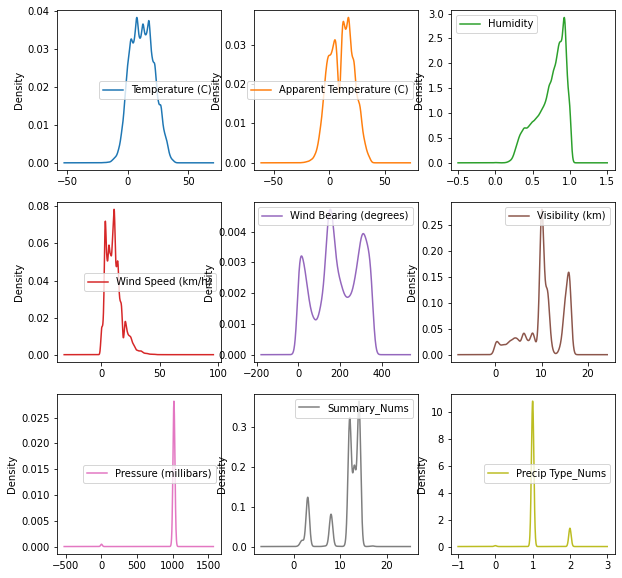

In [71]:
# ядерная оценка плотности
fd.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize=(10,10))
pyplot.show()

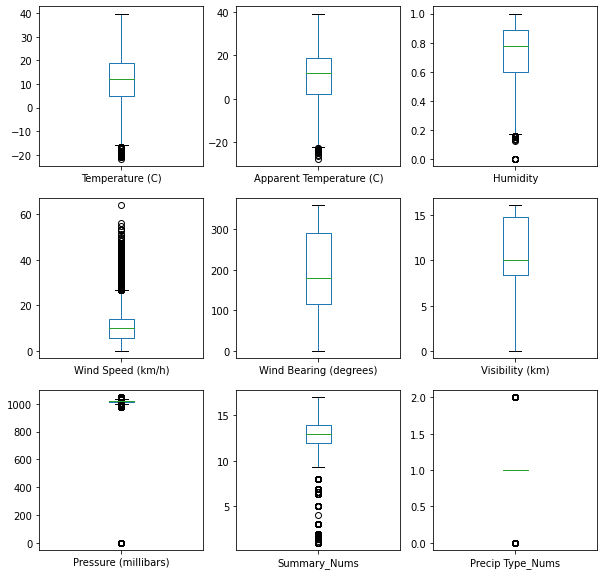

In [72]:
# ящик с усами
fd.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10))
pyplot.show()

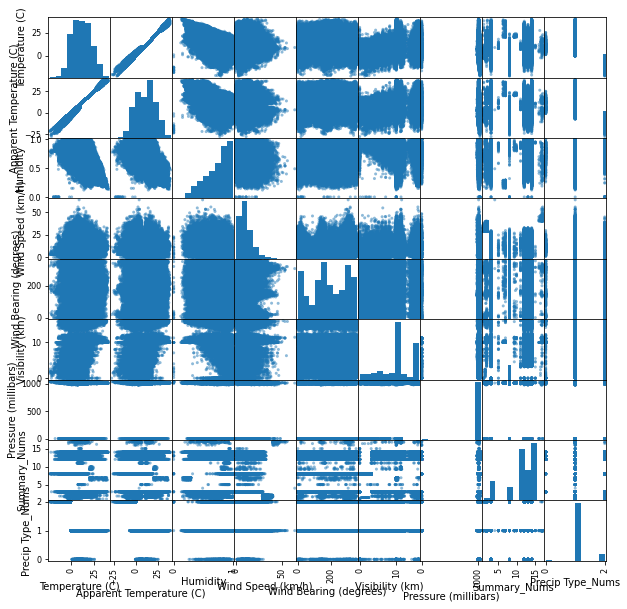

In [19]:
# диаграмма рассеяния
scatter_matrix(fd, figsize=(10,10))
pyplot.show()

<AxesSubplot:>

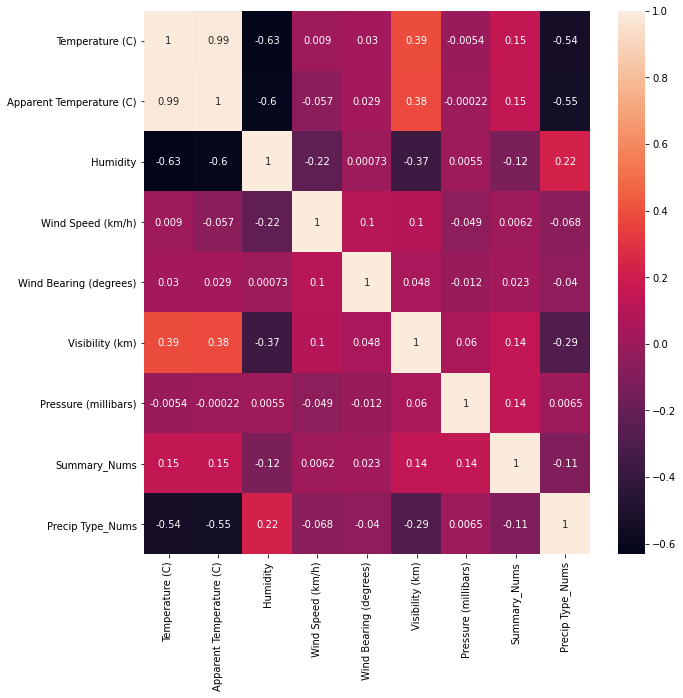

In [20]:
# коррелограмма
fig = pyplot.figure(figsize=(10,10))
sns.heatmap(fd.corr(), annot=True)

## Тестовая и обучаюшая выборки

In [16]:
X = fd.drop(['Apparent Temperature (C)'], axis=1).values
y = fd['Apparent Temperature (C)'].values

validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

## Линейные модели для регрессии

In [17]:
# начальные параметры тестирования и метрика оценки 
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' # отрицательная средняя ошибка => рассматриваем значения по модулю

In [18]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [19]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -1.146661 (0.014135)
LASSO: -1.215769 (0.012118)
EN: -1.201680 (0.011582)
KNN: -1.767804 (0.044977)
CART: -0.010302 (0.002325)
SVR: -5.156127 (0.127420)


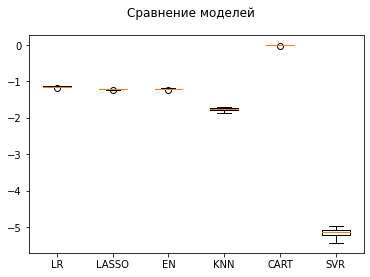

In [20]:
# построим ящик с усами
fig = pyplot.figure()
fig.suptitle('Сравнение моделей') # название
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Стандартизация данных

In [21]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))

In [22]:
results_std = []
names_std = []
kFold = KFold(n_splits = 10, random_state = 7, shuffle = True)

for name, model in pipelines:
    cv_results = cross_val_score(model, X, y, cv = kFold, scoring = scoring)
    results_std.append(cv_results)
    names_std.append(name)
    msg_std = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg_std)

ScaledLR: -1.148236 (0.016715)
ScaledLASSO: -2.680747 (0.040354)
ScaledEN: -14.665554 (0.095632)
ScaledKNN: -0.893739 (0.022018)
ScaledCART: -0.008668 (0.001924)
ScaledSVR: -0.293497 (0.040385)


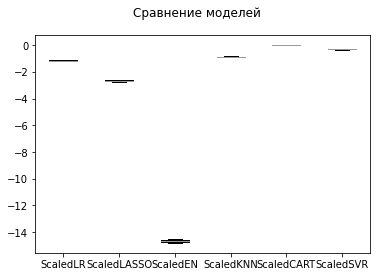

In [23]:
# построим ящик с усами
fig = pyplot.figure()
fig.suptitle('Сравнение моделей') # название
ax = fig.add_subplot(111)
pyplot.boxplot(results_std)
ax.set_xticklabels(names_std)
pyplot.show()

## Настройка алгоритмов (подбор параметров)

Для алгоритма DecisionTreeRegressor подберем оптимальный параметр 

In [33]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

max_depth_values = array([20, 50, 75, 100, 120, 150, 165, 175, 180, 200])
param_grid = dict(max_depth=max_depth_values)

In [34]:
model = DecisionTreeRegressor()

kFold = KFold(n_splits = 10, random_state = 7, shuffle = True)

In [35]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kFold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.009487 using {'max_depth': 150}
-0.010126 (0.001966) with: {'max_depth': 20}
-0.010553 (0.001951) with: {'max_depth': 50}
-0.009705 (0.001513) with: {'max_depth': 75}
-0.010307 (0.002126) with: {'max_depth': 100}
-0.010039 (0.001659) with: {'max_depth': 120}
-0.009487 (0.001202) with: {'max_depth': 150}
-0.009979 (0.001931) with: {'max_depth': 165}
-0.009881 (0.001787) with: {'max_depth': 175}
-0.010057 (0.002501) with: {'max_depth': 180}
-0.010457 (0.002515) with: {'max_depth': 200}


## Ансамблиевые методы

In [36]:
ensembles = []

ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB',
AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',
GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',
RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',
ExtraTreesRegressor(n_estimators=10))])))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -1.403783 (0.041890)
ScaledGBM: -0.045885 (0.002967)
ScaledRF: -0.005275 (0.000925)
ScaledET: -0.006512 (0.001398)


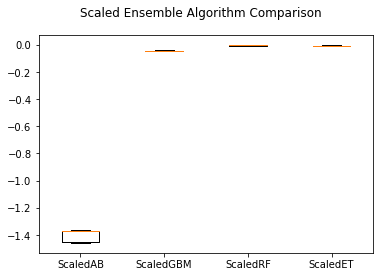

In [37]:
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

лучше всех показал себя ансамблиевый метод RandomForestRegressor

## Предсказание

In [42]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = RandomForestRegressor(n_estimators=10)
model.fit(rescaledX, Y_train)

rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_test, predictions))

0.0036470114318005375
